In [ ]:
!pip install visualkeras
!pip install pydot
!sudo install graphviz

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import visualkeras
import os
import itertools
import tqdm
import random
from keras.preprocessing.image import load_img
import PIL
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

import tensorflow as tf 

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import  Activation, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, MaxPool2D,Dropout, Add, AveragePooling2D
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler,  ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import plot_model

from tensorflow.keras.utils import plot_model
import numpy as np
import cv2

warnings.filterwarnings('ignore')

In [200]:
input_path = []
label = []

for cls in os.listdir("Data"):
  for path in os.listdir(os.path.join("Data", cls)):
    if cls == 'Normal':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("Data", cls, path))
  print(input_path[0], label[0])

Data/HeatStress/1671287246.8596928.jpg 1
Data/HeatStress/1671287246.8596928.jpg 1


In [201]:
len(label)
len(input_path)

15216

In [202]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac = 1).reset_index(drop=True)
df.head()

,images,label
0,Data/HeatStress/1671287108.6500168.jpg,1
1,Data/HeatStress/1671287262.772039.jpg,1
2,Data/Normal/1671289239.7136543.jpg,0
3,Data/HeatStress/1671287262.0185673.jpg,1
4,Data/Normal/1671287191.9370816.jpg,0


In [203]:
for i in df['images']:
  if '.jpg' not in i:
    print(i)


In [204]:
df = df[df['images'] != 'Data/HeatStress/Thumbs.db']
df = df[df['images'] != 'Data/Normal/Thumbs.db']
df = df[df['images'] != 'Data/HeatStress/11702.jpg']
df = df[df['images'] != 'Data/Normal/666.jpg']

len(df)

15216

In [205]:


l = []

for image in df['images']:
  try:
    img = PIL.Image.open(image)
  except Exception as e:
    l.append(image)

l


[]

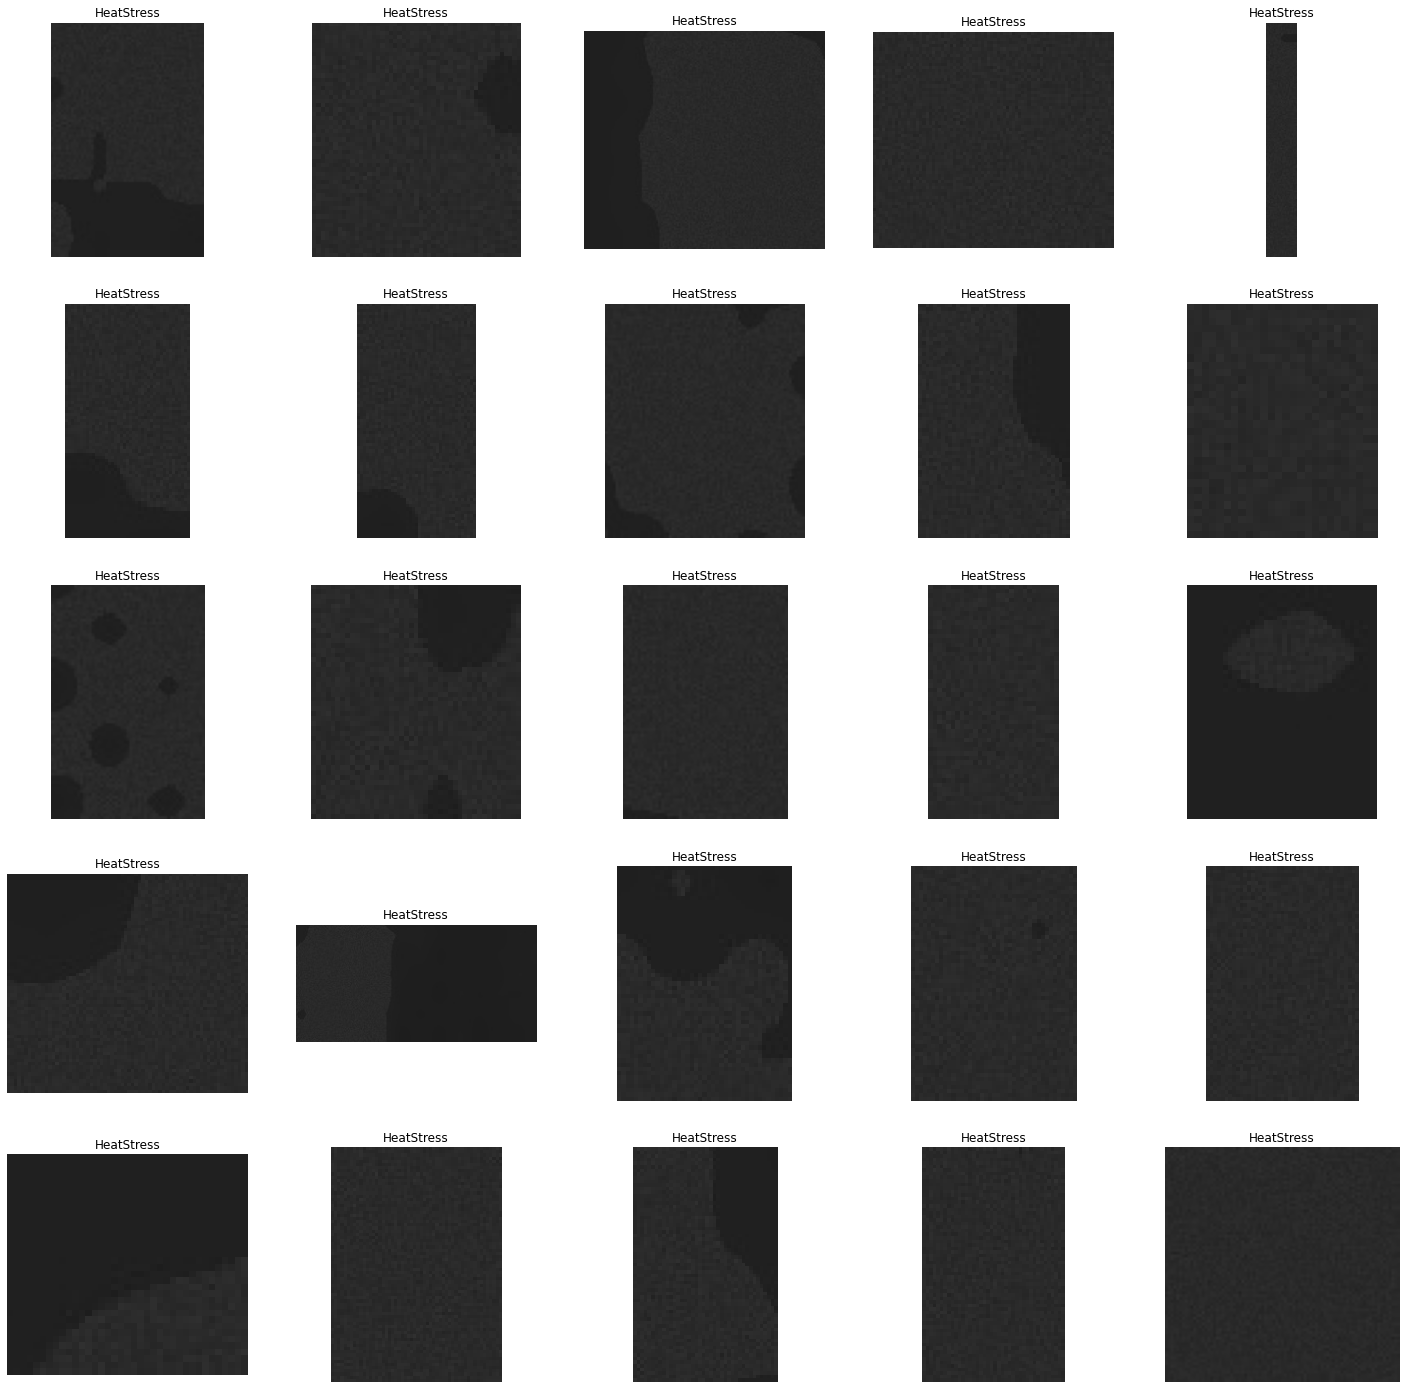

In [206]:
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('HeatStress')
  plt.axis('off')
plt.savefig("HeatStress Figures.jpg")
  

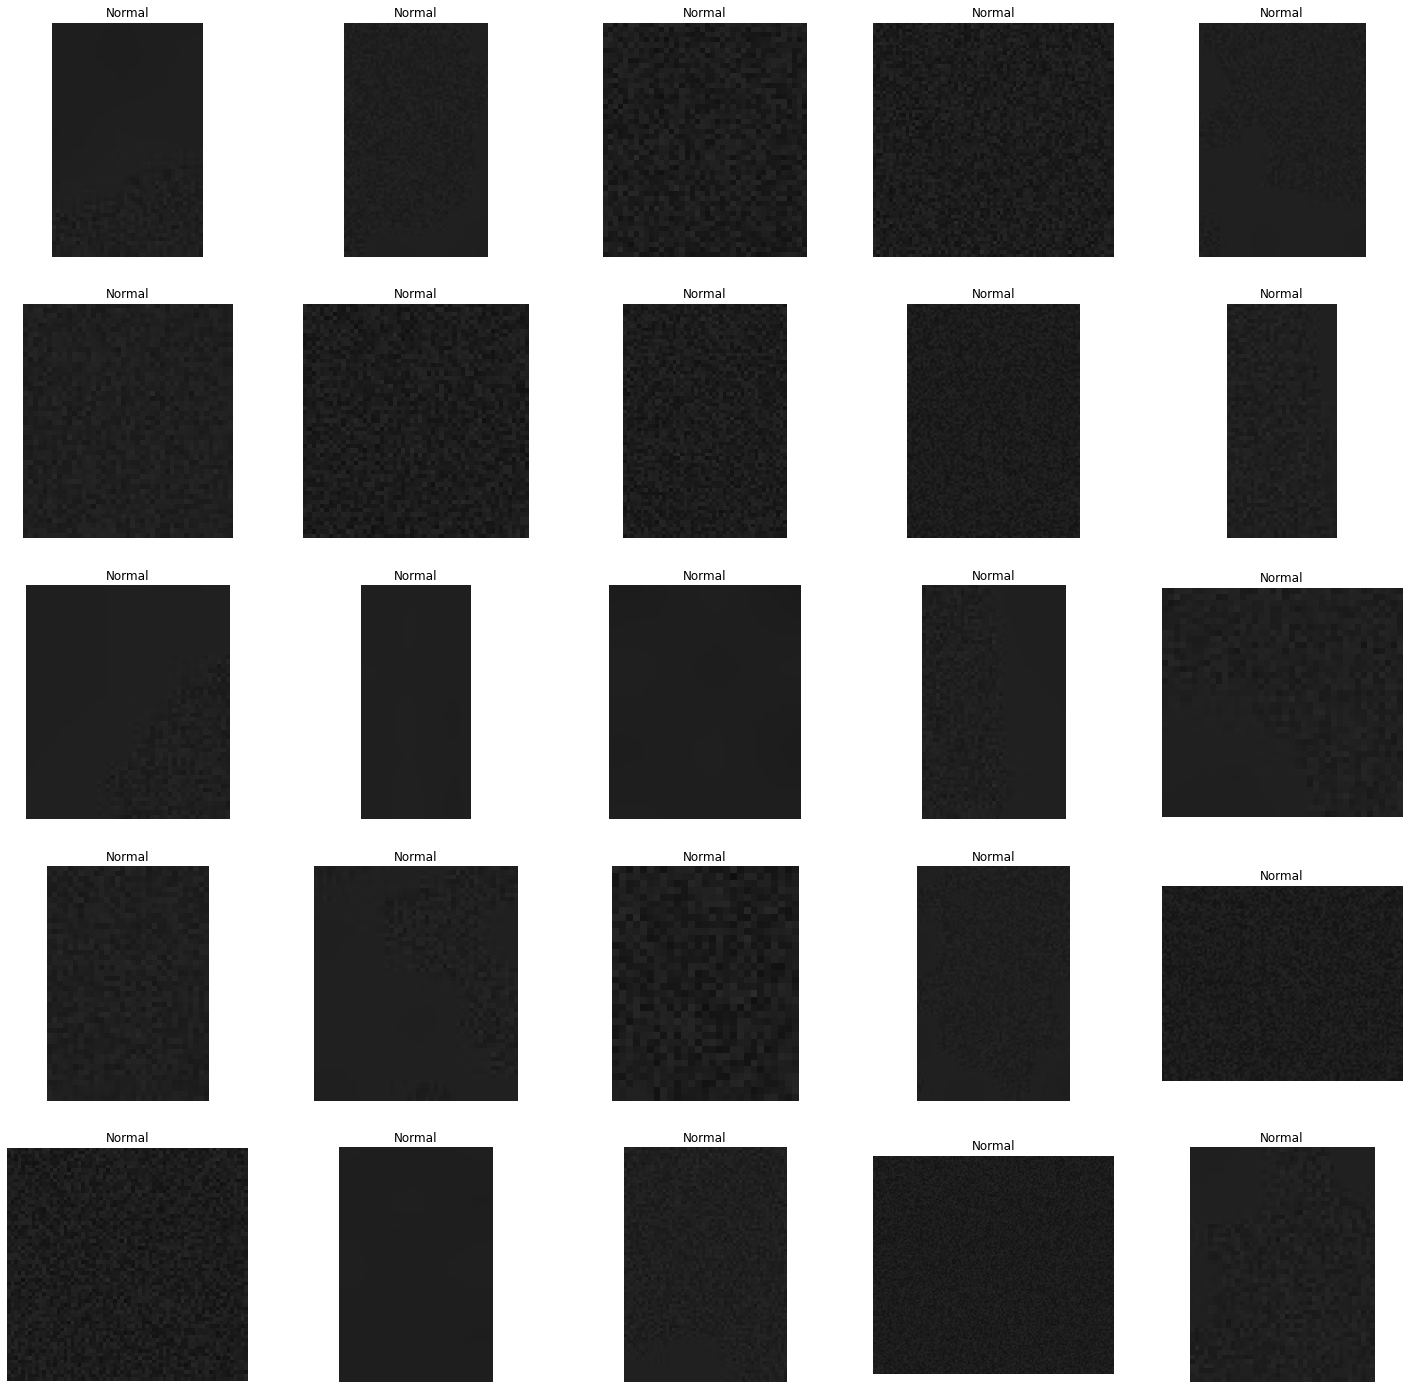

In [207]:
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Normal')
  plt.axis('off')
plt.savefig("Normal Figures.jpg")

<AxesSubplot:xlabel='label', ylabel='count'>

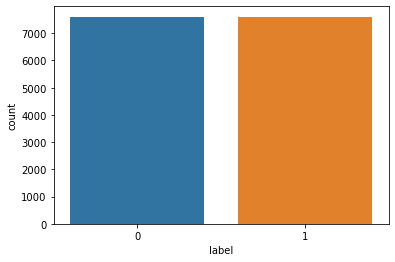

In [208]:
sns.countplot(df['label'])

In [209]:
df['label'] = df['label'].astype('str')

In [210]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train.head()

,images,label
14537,Data/HeatStress/1671287154.9500554.jpg,1
8351,Data/HeatStress/1671287124.2417312.jpg,1
11413,Data/HeatStress/1671289196.5443723.jpg,1
4829,Data/HeatStress/1671287238.8664412.jpg,1
8698,Data/HeatStress/1671289176.1681826.jpg,1


In [211]:


train_generator=ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    fill_mode='nearest'
)


val_generator = ImageDataGenerator(
    rescale=1./255
)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary',
    color_mode="grayscale",
    
    )

val_iterator = train_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary',
    color_mode="grayscale",
    
    )

print(tf.shape(val_iterator.next()[0]))

Found 12172 validated image filenames belonging to 2 classes.
Found 3044 validated image filenames belonging to 2 classes.
tf.Tensor([512 128 128   1], shape=(4,), dtype=int32)


In [212]:
def mai_Net():
    model = tf.keras.models.Sequential([
                                        Conv2D(16, (2,2), activation='relu', input_shape=(128,128, 1)),
                                        MaxPool2D((2,2)),
                                        Conv2D(32, (2,2), activation='relu'),
                                        MaxPool2D((2,2)),
                                        Conv2D(64,(3,3), activation='relu'),
                                        MaxPool2D((2,2)),
                                        Flatten(),
                                        Dense(512, activation='relu'),
                                        Dense(1, activation='sigmoid')
    ])

    return model

model = mai_Net()

In [213]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 127, 127, 16)      80        
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 62, 62, 32)        2080      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 64)      

In [214]:
#@title
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
24/24 [==============================] - 111s 3s/step - loss: 0.4416 - accuracy: 0.7970 - val_loss: 0.2067 - val_accuracy: 0.9041
Epoch 2/10
24/24 [==============================] - 84s 3s/step - loss: 0.1224 - accuracy: 0.9385 - val_loss: 0.0960 - val_accuracy: 0.9494
Epoch 3/10
24/24 [==============================] - 80s 3s/step - loss: 0.1150 - accuracy: 0.9426 - val_loss: 0.1122 - val_accuracy: 0.9458
Epoch 4/10
24/24 [==============================] - 96s 4s/step - loss: 0.1202 - accuracy: 0.9424 - val_loss: 0.1349 - val_accuracy: 0.9353
Epoch 5/10
24/24 [==============================] - 89s 4s/step - loss: 0.1131 - accuracy: 0.9424 - val_loss: 0.0947 - val_accuracy: 0.9520
Epoch 6/10
24/24 [==============================] - 90s 4s/step - loss: 0.0949 - accuracy: 0.9508 - val_loss: 0.0873 - val_accuracy: 0.9537
Epoch 7/10
24/24 [==============================] - 85s 4s/step - loss: 0.0885 - accuracy: 0.9548 - val_loss: 0.0837 - val_accuracy: 0.9553
Epoch 8/10
24/24 [=

<Figure size 432x288 with 0 Axes>

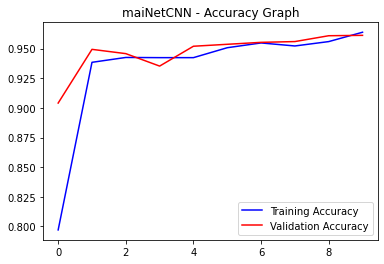

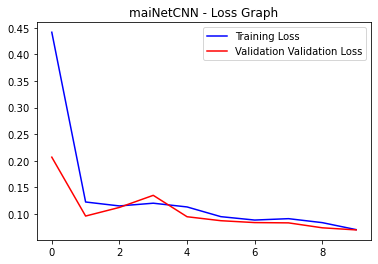

<Figure size 432x288 with 0 Axes>

In [215]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc,'b', label='Training Accuracy')
plt.plot(epochs, val_acc,'r', label='Validation Accuracy')
plt.title('maiNetCNN - Accuracy Graph')
plt.legend()
plt.savefig("maiNetCNN - Accuracy Graph.jpg")
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss,'b', label='Training Loss')
plt.plot(epochs, val_loss,'r', label='Validation Validation Loss')
plt.title('maiNetCNN - Loss Graph')
plt.legend()
plt.savefig("maiNetCNN - Loss Graph.jpg")
plt.figure()


In [216]:
model.save('mai_Net2_dec17_96perc.h5')
# model = tf.keras.models.load_model('mai_Net2.h5')

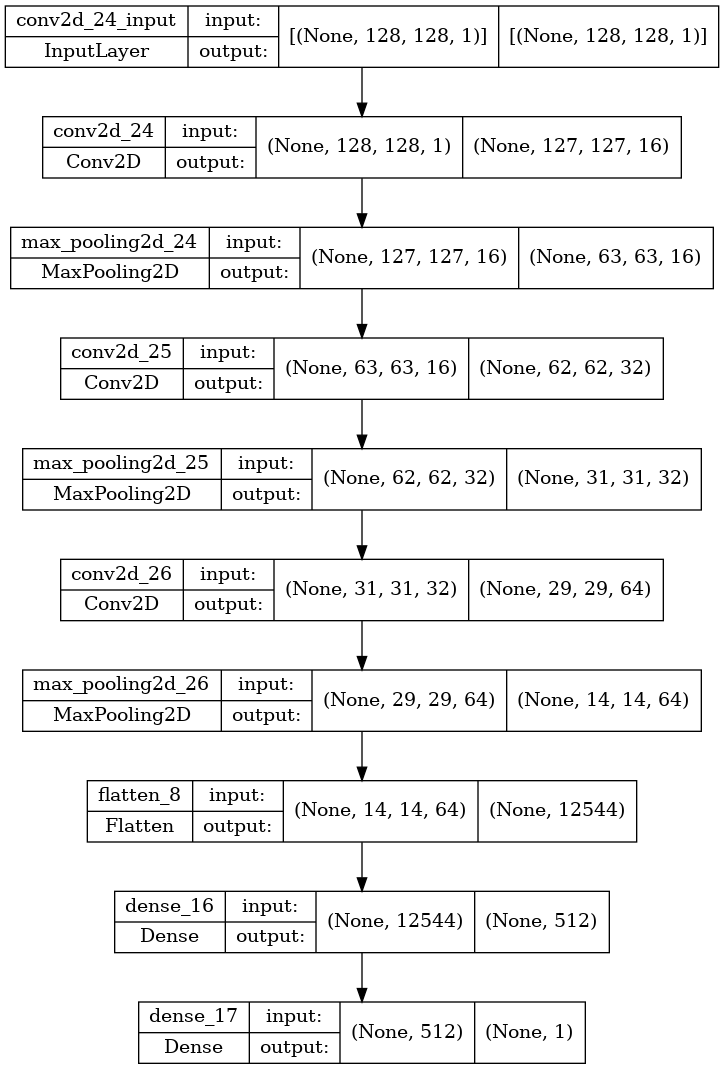

In [217]:
plot_model(model, to_file='Mai_Net_CNN.png', show_shapes=True)

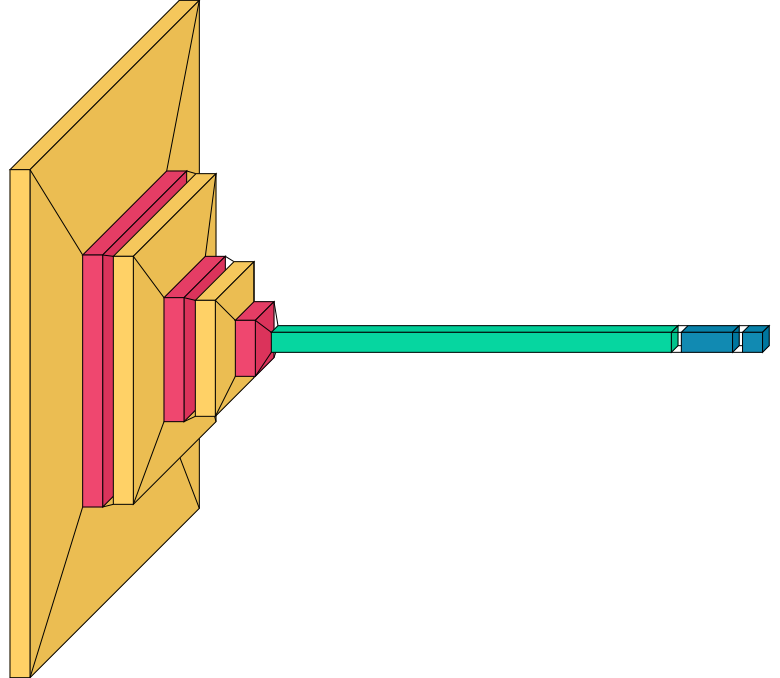

In [218]:
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='mai_net CNN - visualized.png').show() # write and show
visualkeras.layered_view(model)

In [220]:
paths=["testNormal", "testHeatStress"]
targ = 0
target = os.listdir(paths[targ])
classes = ["NormalDesu", "HeatStress"]

norms = 0
heats = 0

for img in target:
    full_path = os.path.join(paths[targ],img )
#     numpy image -> keras image tensor
#     img = tf.keras.preprocessing.image.load_img(full_path, target_size=(128, 128), color_mode='grayscale')
    img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor /= 255. 
#     print(img_tensor.shape)
    
    res = model.predict(np.array(img_tensor).reshape(-1, 128, 128, 1))
    sres = np.squeeze(res)
    rsres = round(float(sres))
    print(f"{classes[rsres]} -> {full_path}")
    
    if rsres == 0 : norms += 1
    else : heats += 1
        
print(f"Normal : {norms} - Heats : {heats}")
#     arged = np.argmax(res)
#     result = classes[np.argmax(np.squeeze(res))]
#     print(f" Model Result -> {result}")

    
# for img in normal:
#     imgg = cv2.imread(os.path.join("testNormal",img), cv2.IMREAD_GRAYSCALE)
#     imgg = cv2.resize(imgg, (128, 128))/255.0
#     res = model.predict(np.array(imgg).reshape(-1, 128, 128, 1))

#     result = classes[np.argmax(np.squeeze(res))]
# #     if res[0][0] > .50: result = "HeatStress"
# #     else: result = "Normal"
    
#     print(f"Totest -> {img}, Model Result -> {np.argmax(np.squeeze(res))}, Identification -> {result}")


NormalDesu -> testNormal/noraml1669874563.0029411.jpg
NormalDesu -> testNormal/noraml1669874561.2592492.jpg
NormalDesu -> testNormal/noraml1669874561.077049.jpg
NormalDesu -> testNormal/noraml1669874561.4090576.jpg
NormalDesu -> testNormal/noraml1669874562.9061685.jpg
NormalDesu -> testNormal/noraml1669874561.345571.jpg
NormalDesu -> testNormal/noraml1669874562.399357.jpg
NormalDesu -> testNormal/noraml1669874562.5046961.jpg
NormalDesu -> testNormal/noraml1669874562.684121.jpg
HeatStress -> testNormal/noraml1669874562.055913.jpg
HeatStress -> testNormal/noraml1669874562.6516476.jpg
NormalDesu -> testNormal/noraml1669874562.0315547.jpg
NormalDesu -> testNormal/noraml1669874561.4954429.jpg
NormalDesu -> testNormal/noraml1669874561.9033673.jpg
NormalDesu -> testNormal/noraml1669874561.3128002.jpg
NormalDesu -> testNormal/noraml1669874562.335993.jpg
NormalDesu -> testNormal/noraml1669874562.007765.jpg
NormalDesu -> testNormal/noraml1669874562.8195415.jpg
HeatStress -> testNormal/noraml1669